In [3]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# 6.1 - Initialization

In [20]:
#(a) Load the sound files. Each of the N = 2 sources is sampled at at 8192 Hz and contains p = 18000 samples.
s = np.array([np.loadtxt("sounds/sound1.dat"), np.loadtxt("sounds/sound2.dat")])
N = s.shape[0]

In [196]:
#(b) Create a random (& invertible) N ×N mixing matrix A and mix the sources: x(α) = As(α)
A = np.zeros((N, N))

#Use any mixing matrix (good and bad results)
#while np.linalg.det(A) == 0:
#    A = np.random.uniform(0.0, 1.0, (N, N))
#Force "good enough" mixing matrix (only good results)
while np.linalg.det(A) < .7:
    A = np.random.uniform(0.0, 1.0, (N, N))
#Force "good enough" mixing matrix (only good results), but flip sources
#while np.linalg.det(A) == 0 or  np.linalg.det(A) > -.7:
#    A = np.random.uniform(0.0, 1.0, (N, N))

print("Mixing Matrix:\n"+str(A)+"\nDet: "+str(np.linalg.det(A)))
x = np.dot(A, s)
#print(x.shape)
#print(x)

Mixing Matrix:
[[ 0.95382491  0.05043391]
 [ 0.36096789  0.92384212]]
Det: 0.862978598087


In [208]:
#(c) Remove the temporal structure by permuting the columns of the N × p matrix X randomly.
xs = np.random.permutation(x)
#print(xs)

In [209]:
#(d) Calculate the correlations between the sources and the mixtures: ρ(si,xj) = cov(si,xj) / (σsi*σxj)
#p = np.cov(s, x) / (np.var(s) * np.var(x))
#print(p)
#p = [((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1],i,j) for i in range(N) for j in range(N)]
#print(p)
def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p
print(correlations(N, s, x))

[[ 0.99865983  0.36487204]
 [ 0.05407598  0.93157649]]


In [210]:
#(e) Center the data to zero mean.
#print( np.mean(x, axis=1).shape )
x_mean = np.mean(xs, axis=1).reshape(-1,1)
xsc = xs - x_mean
#print(xsc.shape)

In [228]:
#(f) Initialize the unmixing matrix W with random values.
#s = W.x, s: Nxp, x: Nxp -> W: NxN
W = np.random.uniform(0, 1, (N, N))

# 6.2 - Optimization

In [229]:
def fhat(y):
    return 1 / (1 + np.exp(-y))
def fhatpp_fhatp(y):
    return 1 - 2*fhat(y)

In [230]:
#(a) Compute the update matrix ∆W using the “regular” gradient.
def dW(eta, W, x):
    #x0 x1
    #x0 x1
    xv = np.vstack( (x.T, x.T) )
    #x0 x0
    #x1 x1
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    return eta * (np.linalg.pinv(W).T + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))

In [231]:
#(b) Compute the update matrix ∆W using the natural gradient as described in the lecture notes.
def dWnatural(eta, W, x):
    #x0 x1
    #x0 x1
    xv = np.vstack( (x.T, x.T) )
    #x0 x0
    #x1 x1
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    subtotal = (np.eye(W.shape[0]) + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))
    #return eta * np.dot(subtotal, np.dot(W.T, W))
    return eta * np.dot(subtotal, W)

In [232]:
#(c) Choose a suitable learning rate η and apply both versions to the data to unmix the sources.
eta = .2
epsilon = .001
Wa = W.copy()
Wb = W.copy()
AConverged = False
BConverged = False
ssa_for_6_3_d = []
ssb_for_6_3_d = []
print("Initial W:\n"+str(W))
for t in range(1,18000):
    xa = xsc[:,np.random.randint(xsc.shape[1])]

    if not AConverged:
        regular = dW(eta/float(t), Wa, xa)
        if regular.any() > epsilon:
            Wa = Wa + regular
            if t%1000 == 0:
                ssa_for_6_3_d.append(np.sum(np.power(Wa,2)))
        else:
            AConverged = True
            print("(a) converged at: "+str(t))
    else:
        pass
        
    if not BConverged:
        natural = dWnatural(eta/float(t), Wb, xa)
        if natural.any() > epsilon:
            Wb = Wb + natural
            if t%1000 == 0:
                ssb_for_6_3_d.append(np.sum(np.power(Wb,2)))
        else:
            BConverged = True
            print("(b) converged at: "+str(t))
    else:
        pass
print("Wa:\n"+str(Wa))
print("Wb:\n"+str(Wb))

Initial W:
[[ 0.61720103  0.10060574]
 [ 0.66207574  0.96536511]]
Wa:
[[ 1.49892241 -0.60559039]
 [ 0.28001175  1.65188363]]
Wb:
[[ 1.56006497 -0.4813623 ]
 [ 0.56401304  3.35894277]]


# 6.3 - Results

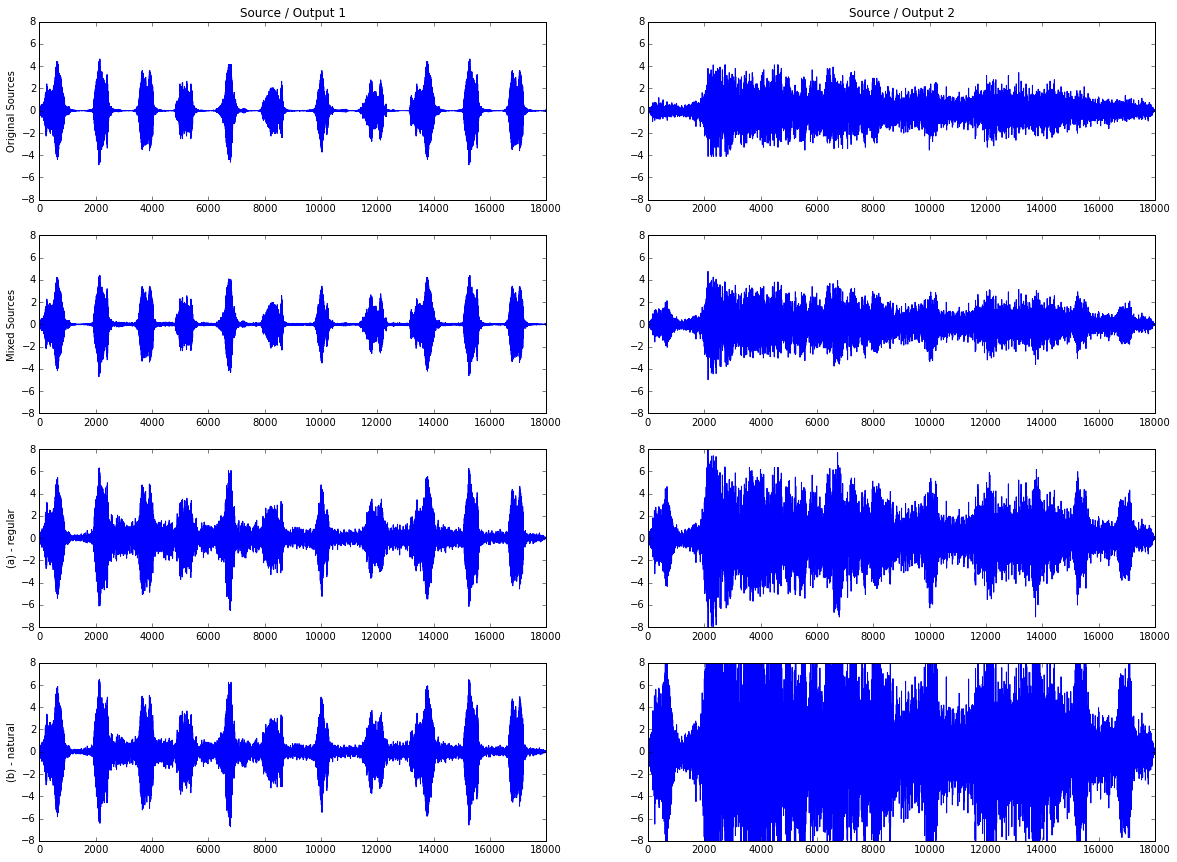

In [233]:
#(a) Plot & Play 
#(i) the original sounds (e.g. use scipy.io.wavfile to save playable files), 
#(ii) the mixed sources (before and after the data permutation), 
#and the recovered signals (estimated sources) ˆs = Wx using the unpermuted data.

#retrieve shats - ^s
shata = np.dot(Wa, x)
shata_decentered = shata + x_mean
shatb = np.dot(Wb, x)
shatb_decentered = shatb + x_mean

#Check correlations, to check whcih source goes to which output channel
regularcors = buildcorrelations(N, shata_decentered, s)
naturalcors = buildcorrelations(N, shatb_decentered, s)

isflippedregular = (regularcors[0,0] < regularcors[0,1]) and (regularcors[1,0] > regularcors[1,1])
isflippednatural = (naturalcors[0,0] < naturalcors[0,1]) and (naturalcors[1,0] > naturalcors[1,1])
if isflippedregular:
    print("Regular is flipped.")
if isflippednatural:
    print("Natural is flipped.")


#(i)
fig = plt.figure(figsize=(20,30))
limits = [-8,8]

ax1 = plt.subplot(821)
ax1.plot(range(s.shape[1]), s[0])
plt.title('Source / Output 1')
plt.ylabel('Original Sources')
ax1.set_ylim(limits)

ax2 = plt.subplot(822)
ax2.plot(range(s.shape[1]), s[1])
plt.title('Source / Output 2')
ax2.set_ylim(limits)


#(ii)
ax1 = plt.subplot(823)
ax1.plot(range(x.shape[1]), x[0])
ax1.set_ylim(limits)
plt.ylabel('Mixed Sources')

ax2 = plt.subplot(824)
ax2.plot(range(x.shape[1]), x[1])
ax2.set_ylim(limits)

#(iii)
ax3 = plt.subplot(825)
ax3.set_ylim(limits)
plt.ylabel('(a) - regular')
if isflippedregular:
    ax3.plot(range(shata_decentered.shape[1]), shata_decentered[1])
else:
    ax3.plot(range(shata_decentered.shape[1]), shata_decentered[0])

ax4 = plt.subplot(826)
ax4.set_ylim(limits)
if isflippedregular:
    ax4.plot(range(shata_decentered.shape[1]), shata_decentered[0])
else:
    ax4.plot(range(shata_decentered.shape[1]), shata_decentered[1])

ax5 = plt.subplot(827)
ax5.set_ylim(limits)
plt.ylabel('(b) - natural')
if isflippednatural:
    ax5.plot(range(shatb_decentered.shape[1]), shatb_decentered[1])
else:
    ax5.plot(range(shatb_decentered.shape[1]), shatb_decentered[0])

ax6 = plt.subplot(828)
ax6.set_ylim(limits)
if isflippednatural:
    ax6.plot(range(shatb_decentered.shape[1]), shatb_decentered[0])
else:
    ax6.plot(range(shatb_decentered.shape[1]), shatb_decentered[1])


plt.show()

In [234]:
#(b) Calculate the correlations (as above) between the true sources and the estimations.
mixings = buildcorrelations(N, s, x)
natural_mean = buildcorrelations(N, shatb_decentered, x)
regular_mean = buildcorrelations(N, shata_decentered, x)

print("\nMixes")
print(mixings)
print("\nRegular")
print(regular_mean)
print("\nNatural")
print(natural_mean)


Mixes
[[ 0.99865983  0.36487204]
 [ 0.05407598  0.93157649]]

Regular
[[ 0.9076697  -0.00690645]
 [ 0.53508462  0.99051231]]

Natural
[[ 0.94782306  0.10151806]
 [ 0.53406576  0.99067774]]


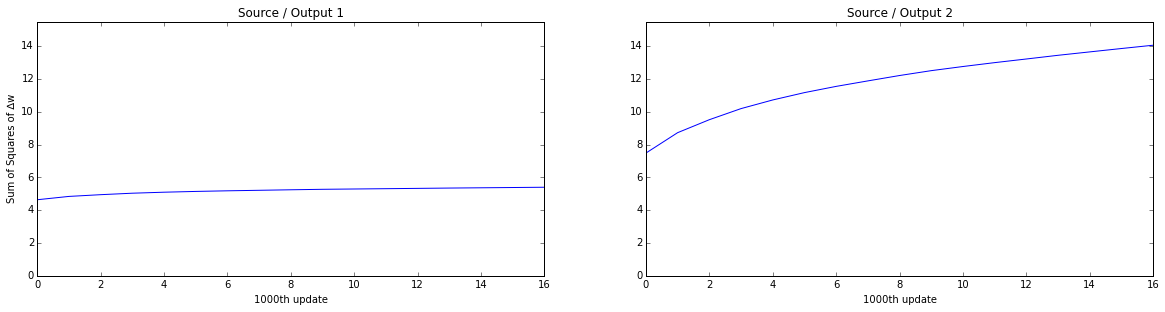

In [235]:
#(c) For every 1000th update, plot ||∆W||2F :=  Ni=1,j=1(∆wi,j)2 to compare the convergence speed for the two gradient methods. Whiten your data before applying ICA and compare the learning speeds again. Describe the differences between the two variants of the learning algorithm.

#print(ssa_for_6_3_d)
#print(ssb_for_6_3_d)

maxy = np.max([np.max(ssa_for_6_3_d), np.max(ssb_for_6_3_d)])
maxy = maxy*1.1 #add some space

fig = plt.figure(figsize=(20,10))
ylimits = [0, maxy]

ax1 = plt.subplot(221)
ax1.plot(range(len(ssa_for_6_3_d)), ssa_for_6_3_d)
plt.title('Source / Output 1')
plt.ylabel('Sum of Squares of ∆w')
plt.xlabel('1000th update')
ax1.set_ylim(ylimits)

ax2 = plt.subplot(222)
ax2.plot(range(len(ssb_for_6_3_d)), ssb_for_6_3_d)
plt.title('Source / Output 2')
plt.xlabel('1000th update')
ax2.set_ylim(ylimits)
plt.show()


In [195]:
#(d) Plot the density of the mixed, unmixed, and true signals & interpret your results.